In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [3]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [4]:
from plotting import plot_ts

In [5]:
from load_dataset import Dataset
dataset = Dataset('../data/dataset/')

### Предсказание одномерного ряда на одну точку вперед

#### Выгрузим одномерный ряд alcohol_sales 

In [6]:
ts = dataset['alcohol_sales.csv']

<AxesSubplot:xlabel='0'>

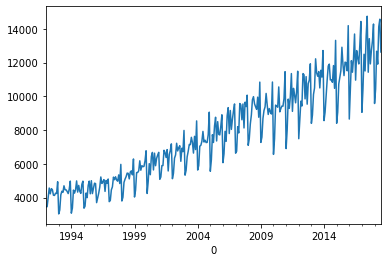

In [7]:
ts.plot()

#### Напишем функцию, которая переводит time series в матрицу обьекты-признаки

In [8]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> pd.DataFrame:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [9]:
NUM_LAGS = 24
X, y = transform_into_matrix(ts, NUM_LAGS)

#### Сделаем необходимый reshape к двумерному виду для сверточного слоя и разобьем на train, test 

In [10]:
X = X.reshape((X.shape[0], X.shape[1], 1))

split_idx = int(len(ts) * 0.7)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

In [11]:
X[0]

array([[3459],
       [3458],
       [4002],
       [4564],
       [4221],
       [4529],
       [4466],
       [4137],
       [4126],
       [4259],
       [4240],
       [4936],
       [3031],
       [3261],
       [4160],
       [4377],
       [4307],
       [4696],
       [4458],
       [4457],
       [4364],
       [4236],
       [4500],
       [4974]], dtype=int64)

In [12]:
y[0]

3075

#### Зададим входной сверточный слой модели.

In [13]:
model = Sequential()

In [14]:
### Обратим внимание на то, что для временных рядов используется свертка только в одном направлении по временной
### шкале - поэтому Conv1D
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))

#### Добавим Pooling для борьбы с переобучением (наличие/отсутствие пулинга как и выбор его типа опционален и зависит от длины вашего ряда, сложности паттерна и т.д., что влияет на переобучение вашей модели) 

In [15]:
model.add(MaxPooling1D())

#### Добавим слой Flatten для перехода к одномерному формату входных данных для полносвязной сети

In [16]:
model.add(Flatten())

#### Добавим пару промежуточных полносвязных слоев и выходной слой с одним нейроном для предсказания одной точки

In [17]:
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

In [18]:
model.compile(optimizer='adam', loss='mse')

In [19]:
model.fit(X_train, y_train, epochs=400, verbose=0)

In [20]:
y_pred = model.predict(X_test).flatten()

<AxesSubplot:>

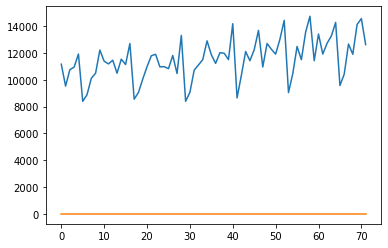

In [21]:
pd.Series(y_test).plot()
pd.Series(y_pred).plot()

### Векторное предсказание для одномерного ряда

Попробуем решить аналогичную предыдущему занятию задачу предсказания вектора следующих точек, но теперь добавим
в модель признаки, сгенерённые сверточным слоем 

#### 1) Возьмем функцию трансформации ряда из прошлого занятия

In [22]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

#### 2) Приведем входные данные к двумерному виду

In [23]:
NUM_LAGS = 24
NUM_OUTPUT = 12
X, y = transform_ts_into_matrix(ts, NUM_LAGS, NUM_OUTPUT)
X = X.reshape((X.shape[0], X.shape[1], 1))

#### 3) Разобьем на трейн и тест, отложив в качестве теста последние 12 точек

In [40]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

#### 4) Постройте сеть из CNN слоев, соединенных с полносвязными слоями 

In [1]:
# your code here

#### 5) Обучите модель

In [2]:
# your code here

#### 5) Постройте предсказания (не забудьте вызвать метод flatten в конце предсказания)

In [3]:
# your code here

#### 6) Постройте предсказание без добавления сверточных слоев и сравните качество

In [4]:
# your code here

### Предсказание многомерного ряда

Где применение CNN вызывает наибольший интерес, так это в многомерных рядах или рядах с наличием экзогенных признаков, так как позволяет автоматически генерировать большое количество признаков из коррелирующих рядов.

В данном примере мы будем предсказывать каждую компоненту многомерного временного ряда, используя данные из всех компонент, т.е. каждая компонента будет в качестве признаков лаги всех соседних рядов, а CNN будет вычленять из них произвольные признаки.

In [5]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

NameError: name 'pd' is not defined

In [85]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


<AxesSubplot:xlabel='timestamp'>

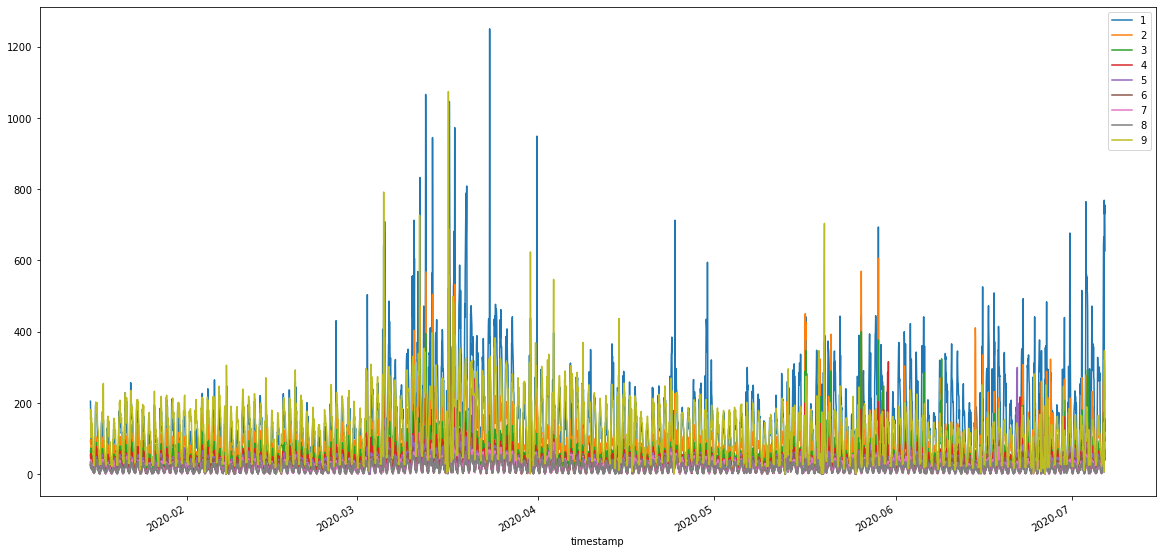

In [86]:
ts.plot(figsize=(20, 10))

In [130]:
import math

from pandas._libs.tslibs.timestamps import Timestamp


def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    'hour_sin': get_hour_sin,
    'hour_cos': get_hour_cos,
    'minute_sin': get_minute_sin,
    'minute_cos': get_minute_cos,
}

In [87]:
ts.fillna(ts.median(), inplace=True)

#### 1) Возьмем функцию из предыдущего занятия (исключая метод flaten в конце, так как CNN принимает как раз 2D данные)

In [88]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x.T)
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [89]:
NUM_LAGS = 14
NUM_DIMS = ts.shape[1]

In [90]:
X, y = transform_multi_ts_into_matrix(ts, NUM_LAGS)

In [91]:
# Видим, что в качестве обьекта мы получаем матрицу, где количество строк равно количеству компонент нашего ряда
# а количество столбцов количеству лагов, которое мы берем для каждой из компонент
X[0].shape

(9, 14)

In [92]:
y[0].shape

(9,)

#### 2) Разбейте на train/test

In [6]:
# your code here

#### 3) Постройте сеть, со сверточным слоем и несколькими полносвязными в конце (подумайте какой shape входных и выходных данных должен быть у первого и последнего слоя)

In [7]:
# your code here

#### 4) Обучите модель

In [8]:
# your code here

#### 5) Сделайте предсказание на тесте

In [9]:
# your code here

#### 6) Сравните полученые предсказания с предсказанием каждой компоненты как отдельного ряда при помощи TimeSeriesPredictor

* Разбейте ряд на 9 одномерных рядов
* Обучите модель TimeSeriesPredictor
* Сделайте батч предсказание на длину X_test
* сравните результаты с CNN

In [136]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    split_idx = 24
    ts_train, ts_test = ts[:-split_idx], ts[-split_idx:]
    return ts_train, ts_test

In [125]:
def make_pipeline(
    ts: pd.Series,
    granularity: str,
    model: callable,
    num_lags=24,
    use_mappers=True,
    **kwargs
) -> Tuple[pd.Series]:
    
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model,
    )
    
    if use_mappers:
        predictor.set_params(mappers=datetime_mappers)
        
    predictor.set_params(**kwargs)
    predictor.fit(train)
    
    in_sample = predictor.predict_batch(train, test)
    out_of_sample = predictor.predict_next(train, len(test))
    
   
    out_of_sample.index = test.index
    
    return train, test, in_sample, out_of_sample

In [10]:
# your code here

#### 7) Сделайте то же самое, что и в 6 пункте, но теперь добавьте в качестве признаков для каждого одномерного ряда лаги от всех остальных 8 рядов. Получился ли результат лучше чем CNN?

In [43]:
# ваш код здесь